# 论文20：神经图灵机
## Alex Graves, Greg Wayne, Ivo Danihelka (2014)

### 可微分读写的外部记忆

NTM通过注意力机制增强了神经网络，使其能够读写外部记忆。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 外部记忆矩阵

In [2]:
class Memory:
    def __init__(self, num_slots, slot_size):
        """
        External memory bank
        
        num_slots: Number of memory locations (N)
        slot_size: Size of each memory vector (M)
        """
        self.num_slots = num_slots
        self.slot_size = slot_size
        
        # Initialize memory to small random values
        self.memory = np.random.randn(num_slots, slot_size) * 0.01
    
    def read(self, weights):
        """
        Read from memory using attention weights
        
        weights: (num_slots,) attention distribution
        Returns: (slot_size,) weighted combination of memory rows
        """
        return np.dot(weights, self.memory)
    
    def write(self, weights, erase_vector, add_vector):
        """
        Write to memory using erase and add operations
        
        weights: (num_slots,) where to write
        erase_vector: (slot_size,) what to erase
        add_vector: (slot_size,) what to add
        """
        # Erase: M_t = M_{t-1} * (1 - w_t ⊗ e_t)
        erase = np.outer(weights, erase_vector)
        self.memory = self.memory * (1 - erase)
        
        # Add: M_t = M_t + w_t ⊗ a_t
        add = np.outer(weights, add_vector)
        self.memory = self.memory + add
    
    def get_memory(self):
        return self.memory.copy()

# Test memory
memory = Memory(num_slots=8, slot_size=4)
print(f"Memory initialized: {memory.num_slots} slots × {memory.slot_size} dimensions")
print(f"Memory shape: {memory.memory.shape}")

Memory initialized: 8 slots × 4 dimensions
Memory shape: (8, 4)


## 基于内容的寻址

基于内容相似度来关注记忆位置


Content-based addressing:
Key shape: (4,)
Attention weights: [0.05088411 0.15814893 0.07038554 0.18527307 0.15617892 0.31894836
 0.03087709 0.02930399]
Sum of weights: 1.0000


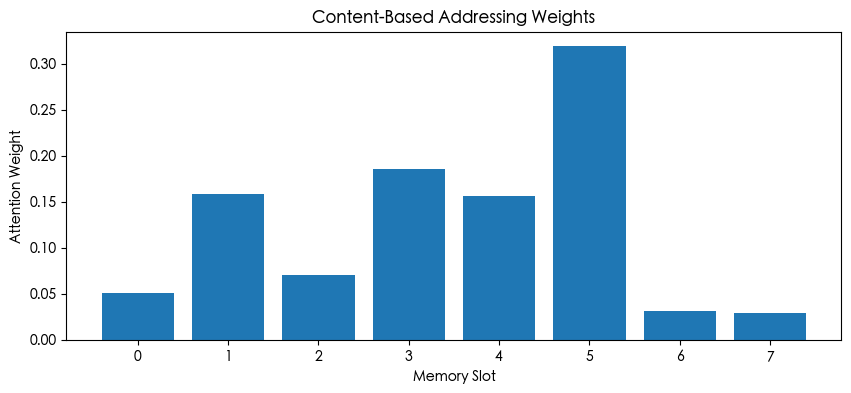

In [3]:
def cosine_similarity(u, v):
    """Cosine similarity between vectors"""
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v) + 1e-8)

def softmax(x, beta=1.0):
    """Softmax with temperature beta"""
    x = beta * x
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x)

def content_addressing(memory, key, beta):
    """
    Content-based addressing
    
    memory: (num_slots, slot_size)
    key: (slot_size,) query vector
    beta: sharpness parameter (> 0)
    
    Returns: (num_slots,) attention weights
    """
    # Compute cosine similarity with each memory row
    similarities = np.array([
        cosine_similarity(key, memory[i]) 
        for i in range(len(memory))
    ])
    
    # Apply softmax with sharpness
    weights = softmax(similarities, beta=beta)
    
    return weights

# Test content addressing
key = np.random.randn(memory.slot_size)
beta = 2.0

weights = content_addressing(memory.memory, key, beta)
print(f"\nContent-based addressing:")
print(f"Key shape: {key.shape}")
print(f"Attention weights: {weights}")
print(f"Sum of weights: {weights.sum():.4f}")

# Visualize
plt.figure(figsize=(10, 4))
plt.bar(range(len(weights)), weights)
plt.xlabel('Memory Slot')
plt.ylabel('Attention Weight')
plt.title('Content-Based Addressing Weights')
plt.show()

## 基于位置的寻址

基于相对位置转移注意力（用于顺序访问）

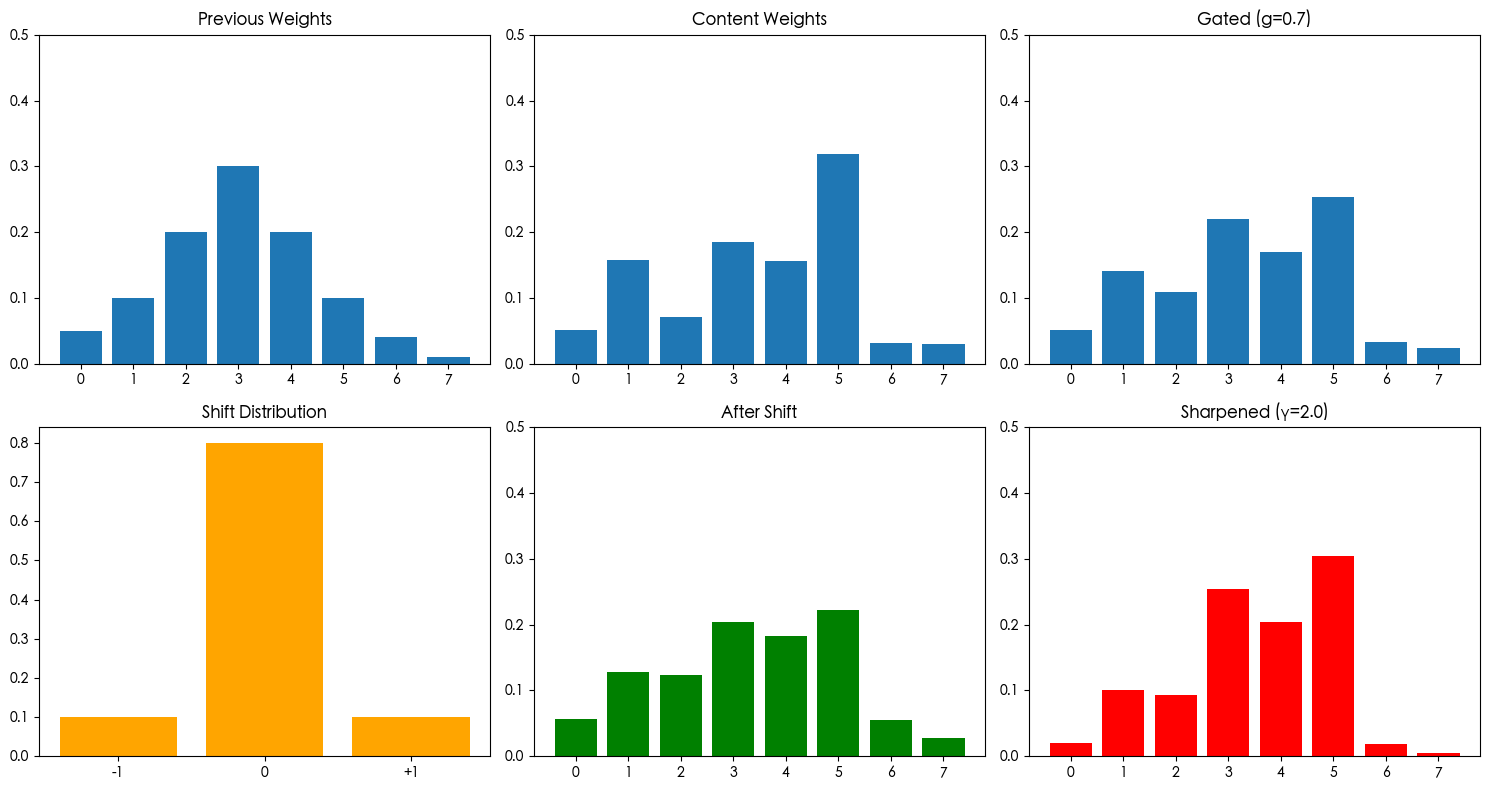


Addressing pipeline complete!


In [4]:
def interpolation(weights_content, weights_prev, g):
    """
    Interpolate between content and previous weights
    
    g: gate in [0, 1]
      g=1: use only content weights
      g=0: use only previous weights
    """
    return g * weights_content + (1 - g) * weights_prev

def convolutional_shift(weights, shift_weights):
    """
    Rotate attention weights by shift distribution
    
    shift_weights: distribution over [-1, 0, +1] shifts
    """
    num_slots = len(weights)
    shifted = np.zeros_like(weights)
    
    # Apply each shift
    for shift_idx, shift_amount in enumerate([-1, 0, 1]):
        rolled = np.roll(weights, shift_amount)
        shifted += shift_weights[shift_idx] * rolled
    
    return shifted

def sharpening(weights, gamma):
    """
    Sharpen attention distribution
    
    gamma >= 1: larger values = sharper distribution
    """
    weights = weights ** gamma
    return weights / (np.sum(weights) + 1e-8)

# Test location-based operations
weights_prev = np.array([0.05, 0.1, 0.2, 0.3, 0.2, 0.1, 0.04, 0.01])
weights_content = content_addressing(memory.memory, key, beta=2.0)

# Interpolation
g = 0.7  # Favor content
weights_gated = interpolation(weights_content, weights_prev, g)

# Shift
shift_weights = np.array([0.1, 0.8, 0.1])  # Mostly stay, little shift
weights_shifted = convolutional_shift(weights_gated, shift_weights)

# Sharpen
gamma = 2.0
weights_sharp = sharpening(weights_shifted, gamma)

# Visualize addressing pipeline
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes[0, 0].bar(range(len(weights_prev)), weights_prev)
axes[0, 0].set_title('Previous Weights')
axes[0, 0].set_ylim(0, 0.5)

axes[0, 1].bar(range(len(weights_content)), weights_content)
axes[0, 1].set_title('Content Weights')
axes[0, 1].set_ylim(0, 0.5)

axes[0, 2].bar(range(len(weights_gated)), weights_gated)
axes[0, 2].set_title(f'Gated (g={g})')
axes[0, 2].set_ylim(0, 0.5)

axes[1, 0].bar(range(len(shift_weights)), shift_weights, color='orange')
axes[1, 0].set_title('Shift Distribution')
axes[1, 0].set_xticks([0, 1, 2])
axes[1, 0].set_xticklabels(['-1', '0', '+1'])

axes[1, 1].bar(range(len(weights_shifted)), weights_shifted, color='green')
axes[1, 1].set_title('After Shift')
axes[1, 1].set_ylim(0, 0.5)

axes[1, 2].bar(range(len(weights_sharp)), weights_sharp, color='red')
axes[1, 2].set_title(f'Sharpened (γ={gamma})')
axes[1, 2].set_ylim(0, 0.5)

plt.tight_layout()
plt.show()

print(f"\nAddressing pipeline complete!")

## 完整NTM读写头

In [5]:
class NTMHead:
    def __init__(self, memory_slots, memory_size, controller_size):
        self.memory_slots = memory_slots
        self.memory_size = memory_size
        
        # Parameters produced by controller
        # Key for content addressing
        self.W_key = np.random.randn(memory_size, controller_size) * 0.1
        
        # Strength (beta)
        self.W_beta = np.random.randn(1, controller_size) * 0.1
        
        # Gate (g)
        self.W_g = np.random.randn(1, controller_size) * 0.1
        
        # Shift weights
        self.W_shift = np.random.randn(3, controller_size) * 0.1
        
        # Sharpening (gamma)
        self.W_gamma = np.random.randn(1, controller_size) * 0.1
        
        # For write head: erase and add vectors
        self.W_erase = np.random.randn(memory_size, controller_size) * 0.1
        self.W_add = np.random.randn(memory_size, controller_size) * 0.1
        
        # Previous weights
        self.weights_prev = np.ones(memory_slots) / memory_slots
    
    def address(self, memory, controller_output):
        """
        Compute addressing weights from controller output
        """
        # Content addressing
        key = np.tanh(np.dot(self.W_key, controller_output))
        beta = np.exp(np.dot(self.W_beta, controller_output))[0] + 1e-4
        weights_content = content_addressing(memory, key, beta)
        
        # Interpolation
        g = 1 / (1 + np.exp(-np.dot(self.W_g, controller_output)))[0]  # sigmoid
        weights_gated = interpolation(weights_content, self.weights_prev, g)
        
        # Shift
        shift_logits = np.dot(self.W_shift, controller_output)
        shift_weights = softmax(shift_logits)
        weights_shifted = convolutional_shift(weights_gated, shift_weights)
        
        # Sharpen
        gamma = np.exp(np.dot(self.W_gamma, controller_output))[0] + 1.0
        weights = sharpening(weights_shifted, gamma)
        
        self.weights_prev = weights
        return weights
    
    def read(self, memory, weights):
        """Read from memory"""
        return memory.read(weights)
    
    def write(self, memory, weights, controller_output):
        """Write to memory"""
        erase = 1 / (1 + np.exp(-np.dot(self.W_erase, controller_output)))  # sigmoid
        add = np.tanh(np.dot(self.W_add, controller_output))
        memory.write(weights, erase, add)

print("NTM Head created with full addressing mechanism")

NTM Head created with full addressing mechanism


## 测试任务：复制序列

NTM的经典任务：将序列从输入复制到输出

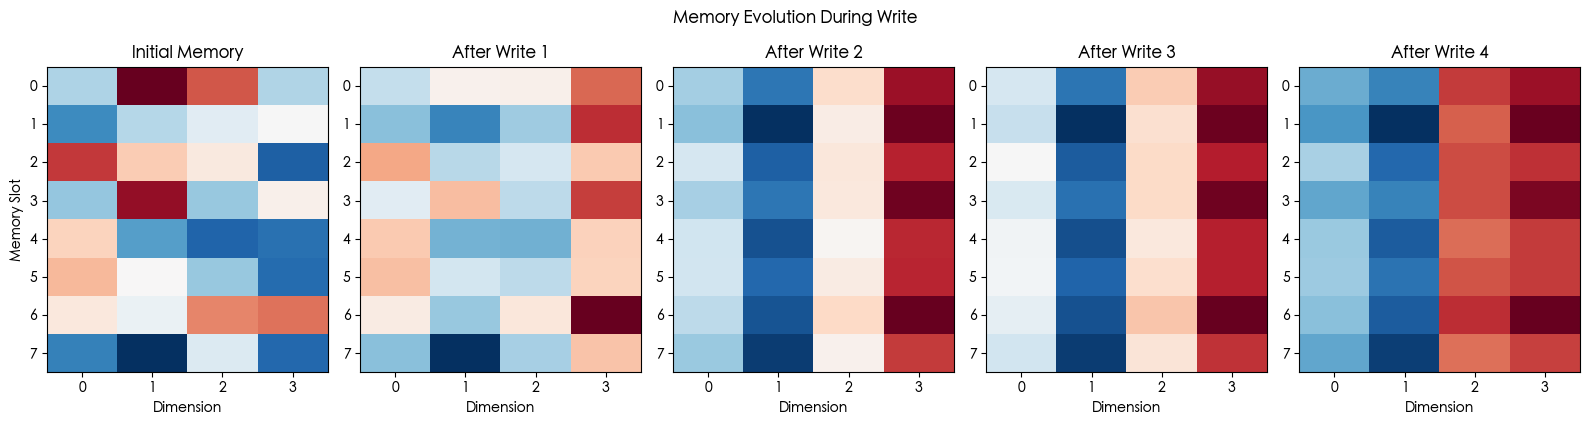

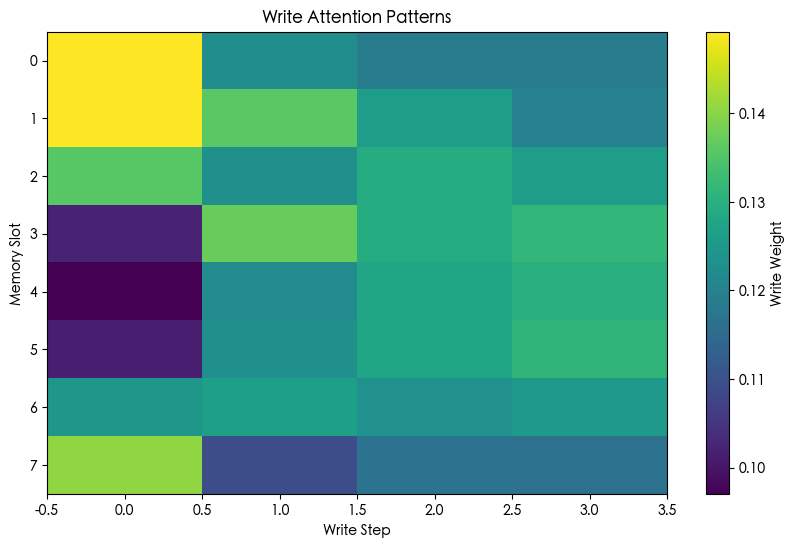


Wrote 4 items to memory


In [6]:
# Simple copy task
memory = Memory(num_slots=8, slot_size=4)
controller_size = 16
head = NTMHead(memory.num_slots, memory.slot_size, controller_size)

# Input sequence
sequence = [
    np.array([1, 0, 0, 0]),
    np.array([0, 1, 0, 0]),
    np.array([0, 0, 1, 0]),
    np.array([0, 0, 0, 1]),
]

# Write phase: store sequence in memory
memory_states = [memory.get_memory()]
write_weights_history = []

for i, item in enumerate(sequence):
    # Simulate controller output (random for demo)
    controller_out = np.random.randn(controller_size)
    
    # Get write weights
    weights = head.address(memory.memory, controller_out)
    write_weights_history.append(weights)
    
    # Write to memory
    head.write(memory, weights, controller_out)
    memory_states.append(memory.get_memory())

# Visualize write process
fig, axes = plt.subplots(1, len(sequence) + 1, figsize=(16, 4))

# Initial memory
axes[0].imshow(memory_states[0], cmap='RdBu', aspect='auto')
axes[0].set_title('Initial Memory')
axes[0].set_ylabel('Memory Slot')
axes[0].set_xlabel('Dimension')

# After each write
for i in range(len(sequence)):
    axes[i+1].imshow(memory_states[i+1], cmap='RdBu', aspect='auto')
    axes[i+1].set_title(f'After Write {i+1}')
    axes[i+1].set_xlabel('Dimension')

plt.tight_layout()
plt.suptitle('Memory Evolution During Write', y=1.05)
plt.show()

# Show write attention patterns
write_weights = np.array(write_weights_history).T

plt.figure(figsize=(10, 6))
plt.imshow(write_weights, cmap='viridis', aspect='auto')
plt.colorbar(label='Write Weight')
plt.xlabel('Write Step')
plt.ylabel('Memory Slot')
plt.title('Write Attention Patterns')
plt.show()

print(f"\nWrote {len(sequence)} items to memory")

## 核心要点

### NTM架构：
1. **控制器**：神经网络（LSTM/FF），产生控制信号
2. **记忆矩阵**：外部记忆（N × M）
3. **读头**：基于注意力的读取
4. **写头**：基于注意力的写入，使用擦除+添加

### 寻址机制：
1. **基于内容**：与记忆内容的相似度
2. **基于位置**：相对转移（顺序访问）
3. **组合**：在内容和位置之间进行插值

### 寻址流程：
```
内容寻址 → 插值 → 转移 → 锐化
```

### 写操作：
- **擦除**：M_t = M_{t-1} ⊙ (1 - w_t ⊗ e_t)
- **添加**：M_t = M_t + (w_t ⊗ a_t)
- 允许选择性修改

### 能力：
- 复制和召回序列
- 学习算法（排序、复制等）
- 泛化到更长的序列
- 可微分的记忆访问

### 局限性：
- 计算开销大（需要对所有记忆进行注意力）
- 难以训练
- 记忆大小固定

### 影响：
- 启发了可微分记忆研究
- 导致：可微分神经计算机（DNC）、记忆网络
- 展示了神经网络可以学习算法
- 现代外部记忆系统的前驱